<a href="https://colab.research.google.com/github/amayaambagaspitiya/CustomerSegment/blob/main/Airline_passengers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

In [ ]:
df = pd.read_csv('/content/AirPassengers.csv')

In [ ]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
df["Month"] = pd.to_datetime(df["Month"])
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [ ]:
df['Log_Passengers'] = np.log(df['#Passengers'])
df.head()

,Month,#Passengers,Log_Passengers
0,1949-01-01,112,4.718499
1,1949-02-01,118,4.770685
2,1949-03-01,132,4.882802
3,1949-04-01,129,4.859812
4,1949-05-01,121,4.795791


In [ ]:
train_df = df[(df['Month'] >= '1949-01-01') & (df['Month'] < '1960-01-01')]
test_df = df[df['Month'] >= '1960-01-01']

# Display the sizes of the training and testing sets
print("Training Set:")
train_df.head()


Training Set:


,Month,#Passengers,Log_Passengers
0,1949-01-01,112,4.718499
1,1949-02-01,118,4.770685
2,1949-03-01,132,4.882802
3,1949-04-01,129,4.859812
4,1949-05-01,121,4.795791


In [ ]:
print("\nTesting Set:")
test_df.head()


Testing Set:


,Month,#Passengers,Log_Passengers
132,1960-01-01,417,6.033086
133,1960-02-01,391,5.968708
134,1960-03-01,419,6.037871
135,1960-04-01,461,6.133398
136,1960-05-01,472,6.156979


In [ ]:
# Fit SARIMA(0,1,1) × (0,1,1) 12 model on log-transformed data
model = SARIMAX(train_df['Log_Passengers'],
                order=(9,0,0),
                enforce_stationarity=False,
                enforce_invertibility=False)
result_Arima = model.fit()

# Generate predictions
preds = result_Arima.predict(start=test_df.index[0], end=test_df.index[-1])

In [ ]:
preds.head()

,predicted_mean
132,6.038160
133,5.987977
134,6.144770
135,6.118288
136,6.159434


In [ ]:
combined_df = pd.concat([test_df, preds.rename('Predicted_Log_Passengers')], axis=1)
combined_df.head()

,Month,#Passengers,Log_Passengers,Predicted_Log_Passengers
132,1960-01-01,417,6.033086,6.038160
133,1960-02-01,391,5.968708,5.987977
134,1960-03-01,419,6.037871,6.144770
135,1960-04-01,461,6.133398,6.118288
136,1960-05-01,472,6.156979,6.159434


In [ ]:
test_df.head(15)

,Month,#Passengers,Log_Passengers
132,1960-01-01,417,6.033086
133,1960-02-01,391,5.968708
134,1960-03-01,419,6.037871
135,1960-04-01,461,6.133398
136,1960-05-01,472,6.156979
137,1960-06-01,535,6.282267
138,1960-07-01,622,6.432940
139,1960-08-01,606,6.406880
140,1960-09-01,508,6.230481
141,1960-10-01,461,6.133398


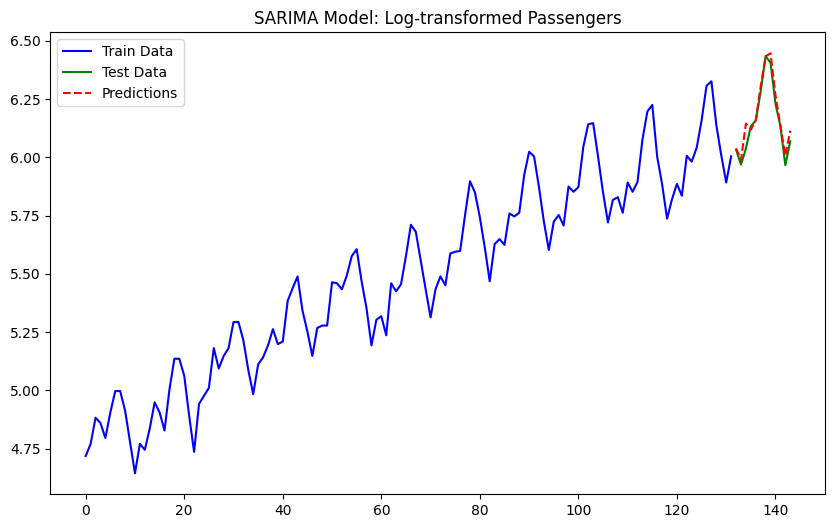

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(train_df.index, train_df['Log_Passengers'], label='Train Data', color='blue')
plt.plot(test_df.index, test_df['Log_Passengers'], label='Test Data', color='green')
plt.plot(preds.index, preds, label='Predictions', color='red', linestyle='--')
plt.title('SARIMA Model: Log-transformed Passengers')
plt.legend()
plt.show()


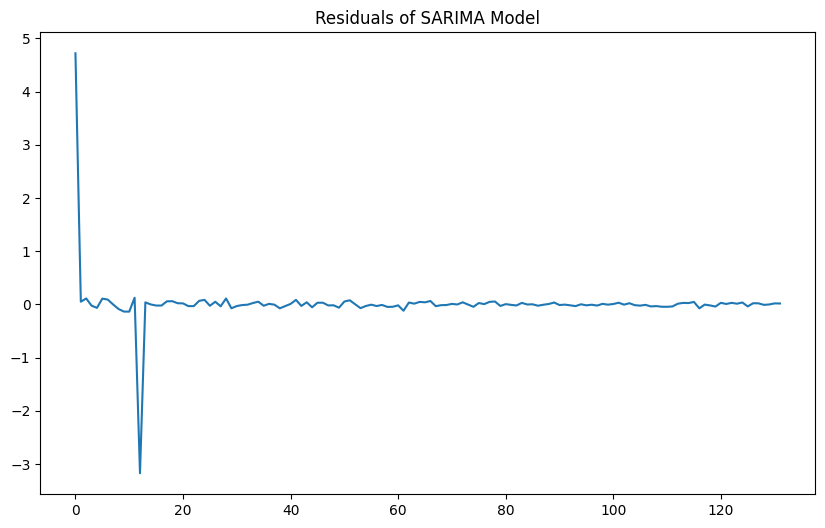

In [ ]:

#residuals
residuals = train_df['Log_Passengers'] - result_Arima.fittedvalues

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of SARIMA Model')
plt.show()

In [ ]:
rmse_value = rmse(test_df['Log_Passengers'], preds)
print(f'Root Mean Squared Error (RMSE): {rmse_value}')


Root Mean Squared Error (RMSE): 0.03998236331445076


In [ ]:
combined_df['Error'] = combined_df['Log_Passengers']-combined_df['Predicted_Log_Passengers']
combined_df.head()

,Month,#Passengers,Log_Passengers,Predicted_Log_Passengers,Error
132,1960-01-01,417,6.033086,6.038160,-0.005074
133,1960-02-01,391,5.968708,5.987977,-0.019269
134,1960-03-01,419,6.037871,6.144770,-0.106899
135,1960-04-01,461,6.133398,6.118288,0.015110
136,1960-05-01,472,6.156979,6.159434,-0.002455


In [ ]:
DLE = 0.05 * np.mean(combined_df['Error'])
print(DLE)

-0.0012737732991229675


In [ ]:
def classify_errors(df, dle):


    df['Error_Category'] = 'Neutral'

    df.loc[df['Error'] > dle, 'Error_Category'] = 'Over-shooter'
    df.loc[df['Error'] < -dle, 'Error_Category'] = 'Under-shooter'

    return df

In [ ]:
df_new = classify_errors(combined_df, DLE)

df_new.head(10)

,Month,#Passengers,Log_Passengers,Predicted_Log_Passengers,Error,Error_Category
132,1960-01-01,417,6.033086,6.038160,-0.005074,Under-shooter
133,1960-02-01,391,5.968708,5.987977,-0.019269,Under-shooter
134,1960-03-01,419,6.037871,6.144770,-0.106899,Under-shooter
135,1960-04-01,461,6.133398,6.118288,0.015110,Over-shooter
136,1960-05-01,472,6.156979,6.159434,-0.002455,Under-shooter
137,1960-06-01,535,6.282267,6.304290,-0.022023,Under-shooter
138,1960-07-01,622,6.432940,6.433280,-0.000340,Under-shooter
139,1960-08-01,606,6.406880,6.446256,-0.039376,Under-shooter
140,1960-09-01,508,6.230481,6.266339,-0.035857,Under-shooter
141,1960-10-01,461,6.133398,6.135871,-0.002473,Under-shooter


In [ ]:
print("DLE Threshold:", DLE)


# Get the values where the error is greater than DLE
errors_greater_than_dle = combined_df[combined_df['Error'] > DLE]
print("Errors greater than DLE (A):\n")
errors_greater_than_dle.head(10)



DLE Threshold: -0.0012737732991229675
Errors greater than DLE (A):



,Month,#Passengers,Log_Passengers,Predicted_Log_Passengers,Error,Error_Category
135,1960-04-01,461,6.133398,6.118288,0.01511,Over-shooter
138,1960-07-01,622,6.432940,6.433280,-0.00034,Under-shooter


In [ ]:
# # Get the values where the error is less than -DLE
errors_less_than_minus_dle = combined_df[combined_df['Error'] < -DLE]
print("\nErrors less than -DLE (B):\n" )
errors_less_than_minus_dle.head(10)


Errors less than -DLE (B):



,Month,#Passengers,Log_Passengers,Predicted_Log_Passengers,Error,Error_Category
132,1960-01-01,417,6.033086,6.038160,-0.005074,Under-shooter
133,1960-02-01,391,5.968708,5.987977,-0.019269,Under-shooter
134,1960-03-01,419,6.037871,6.144770,-0.106899,Under-shooter
136,1960-05-01,472,6.156979,6.159434,-0.002455,Under-shooter
137,1960-06-01,535,6.282267,6.304290,-0.022023,Under-shooter
138,1960-07-01,622,6.432940,6.433280,-0.000340,Under-shooter
139,1960-08-01,606,6.406880,6.446256,-0.039376,Under-shooter
140,1960-09-01,508,6.230481,6.266339,-0.035857,Under-shooter
141,1960-10-01,461,6.133398,6.135871,-0.002473,Under-shooter
142,1960-11-01,390,5.966147,6.007678,-0.041531,Under-shooter


### predict for train

In [ ]:
preds_train = result_Arima.predict(start=train_df.index[0], end=train_df.index[-1])

combined_df_train = pd.concat([train_df, preds_train.rename('Predicted_Log_Passengers')], axis=1)
combined_df_train.head(10)

,Month,#Passengers,Log_Passengers,Predicted_Log_Passengers
0,1949-01-01,112,4.718499,0.000000
1,1949-02-01,118,4.770685,4.718499
2,1949-03-01,132,4.882802,4.770685
3,1949-04-01,129,4.859812,4.882802
4,1949-05-01,121,4.795791,4.859812
5,1949-06-01,135,4.905275,4.795791
6,1949-07-01,148,4.997212,4.905275
7,1949-08-01,148,4.997212,4.997212
8,1949-09-01,136,4.912655,4.997212
9,1949-10-01,119,4.779123,4.912655


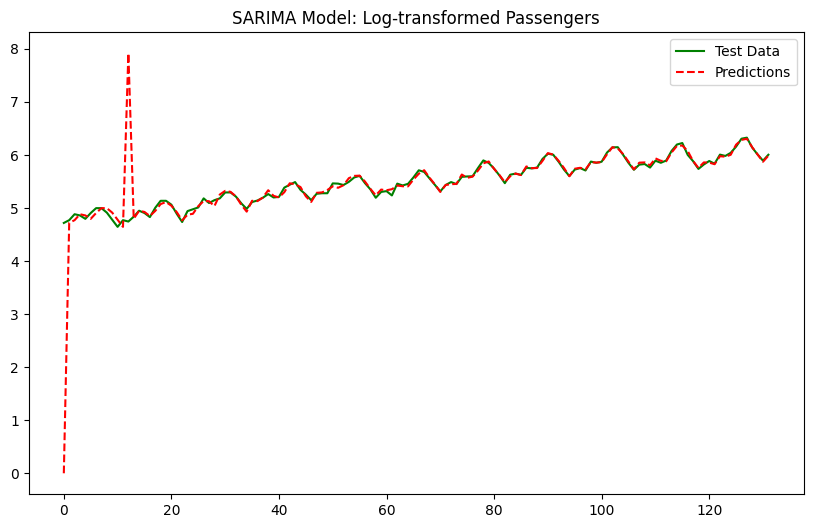

In [ ]:
plt.figure(figsize=(10, 6))
# plt.plot(train_df.index, train_df['Log_Passengers'], label='Train Data', color='blue')
plt.plot(combined_df_train.index, combined_df_train['Log_Passengers'], label='Test Data', color='green')
plt.plot(preds_train.index, preds_train, label='Predictions', color='red', linestyle='--')
plt.title('SARIMA Model: Log-transformed Passengers')
plt.legend()
plt.show()

In [ ]:
combined_df_train.head(10)

,Month,#Passengers,Log_Passengers,Predicted_Log_Passengers
0,1949-01-01,112,4.718499,0.000000
1,1949-02-01,118,4.770685,4.718499
2,1949-03-01,132,4.882802,4.770685
3,1949-04-01,129,4.859812,4.882802
4,1949-05-01,121,4.795791,4.859812
5,1949-06-01,135,4.905275,4.795791
6,1949-07-01,148,4.997212,4.905275
7,1949-08-01,148,4.997212,4.997212
8,1949-09-01,136,4.912655,4.997212
9,1949-10-01,119,4.779123,4.912655


In [ ]:
combined_df_train['Error'] = combined_df_train['Log_Passengers']-combined_df_train['Predicted_Log_Passengers']
combined_df_train.head()

,Month,#Passengers,Log_Passengers,Predicted_Log_Passengers,Error
0,1949-01-01,112,4.718499,0.000000,4.718499
1,1949-02-01,118,4.770685,4.718499,0.052186
2,1949-03-01,132,4.882802,4.770685,0.112117
3,1949-04-01,129,4.859812,4.882802,-0.022990
4,1949-05-01,121,4.795791,4.859812,-0.064022


In [ ]:
preds_train

,predicted_mean
0,0.000000
1,4.718499
2,4.770685
3,4.882802
4,4.859812
...,...
127,6.305132
128,6.145249
129,6.008813
130,5.871723


In [ ]:
rmse_value_train = rmse(train_df['Log_Passengers'], preds_train)
print(f'Root Mean Squared Error (RMSE): {rmse_value_train}')

Root Mean Squared Error (RMSE): 0.49686683220075556


In [ ]:
DLE_train = 0.05 * np.mean(combined_df_train['Error'])
print(DLE)

-0.0012737732991229675


In [ ]:
def classify_errors(df, dle):


    df['Error_Category'] = 'Neutral'

    df.loc[df['Error'] > dle, 'Error_Category'] = 'Over-shooter'
    df.loc[df['Error'] < -dle, 'Error_Category'] = 'Under-shooter'

    return df

In [ ]:
new_df_train = classify_errors(combined_df_train, DLE_train)

new_df_train.head()

,Month,#Passengers,Log_Passengers,Predicted_Log_Passengers,Error,Error_Category
0,1949-01-01,112,4.718499,0.000000,4.718499,Over-shooter
1,1949-02-01,118,4.770685,4.718499,0.052186,Over-shooter
2,1949-03-01,132,4.882802,4.770685,0.112117,Over-shooter
3,1949-04-01,129,4.859812,4.882802,-0.022990,Under-shooter
4,1949-05-01,121,4.795791,4.859812,-0.064022,Under-shooter


In [ ]:

Cat_A = [error for error, category in zip(new_df_train["Error"], new_df_train["Error_Category"]) if category == "Over-shooter"]
Cat_B = [error for error, category in zip(new_df_train["Error"], new_df_train["Error_Category"]) if category == "Under-shooter"]




In [ ]:
Cat_A

[4.718498871295094,
 0.05218575317057095,
 0.11211729813333271,
 0.10948423282619757,
 0.09193749535217588,
 0.12629372529169203,
 0.039164024500521144,
 0.05854062944957761,
 0.06176767501868863,
 0.023064140498163077,
 0.019966505341053598,
 0.06754043069285753,
 0.08606465791301865,
 0.05111165548965335,
 0.11235790931166001,
 0.02680631780179077,
 0.051944442306973926,
 0.011349040520725495,
 0.010494413151402426,
 0.08612892161902153,
 0.04057385321576579,
 0.032105473250895855,
 0.03285116916745512,
 0.05501592661249877,
 0.07848001270684968,
 0.0043221942348488085,
 0.03614135759644821,
 0.014983942953793239,
 0.048092134992168134,
 0.040147320435771405,
 0.06489252546078284,
 0.010845855097167956,
 0.04010768343732529,
 0.026582716308981347,
 0.006739344700203986,
 0.0482955074175031,
 0.05570073226121952,
 0.005948644678531956,
 0.029408974310879188,
 0.0028953535459317337,
 0.00838211623695706,
 0.03650289652408478,
 0.0031031797718723553,
 0.011417567402207673,
 0.0083937674

In [ ]:
Cat_B

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

def build_and_predict_ann(error_list, lags=[1, 2, 12], epochs=50, batch_size=4):


    data = pd.DataFrame(error_list, columns=["Error"])
    for lag in lags:
        data[f"Lag_{lag}"] = data["Error"].shift(lag)

    # Drop rows with NaN values (due to lags)
    data = data.dropna()

    # Define inputs (features) and target (labels)
    X = data[[f"Lag_{lag}" for lag in lags]].values
    y = data["Error"].values

    # Step 2: Build the ANN model
    model = Sequential()
    model.add(Dense(2, input_dim=len(lags), activation='relu'))  # Hidden layer with 2 nodes
    model.add(Dense(1))  # Output layer

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    # Step 3: Train the ANN model
    model.fit(X, y, epochs=epochs, verbose=1, batch_size=batch_size)


    print( 'XXXXXXXXXXXXXX')
    print(X)
    # Step 4: Generate predictions
    predictions = model.predict(X)

    # Step 5: Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y, label="Actual Values", marker='o', linestyle='-', color='blue')
    plt.plot(predictions, label="Predicted Values", marker='x', linestyle='--', color='red')
    plt.title("Actual vs. Predicted Values")
    plt.xlabel("Index")
    plt.ylabel("Error Value")
    plt.legend()
    plt.grid()
    plt.show()

    return predictions , model


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0037  
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2656e-04 
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014     
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017     
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010     
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012     
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010     
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3936e-04 
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7052e-04 
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.7071e-04 
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4339e-04 
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s

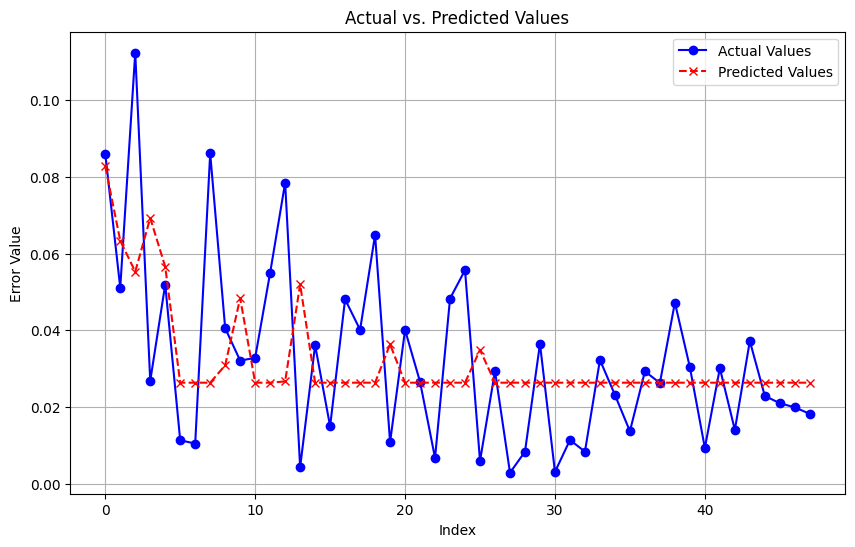

In [ ]:
predictions , Model_A_Ann = build_and_predict_ann(Cat_A)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6304e-04 
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6263e-04 
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9971e-04 
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5726e-04 
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1201e-04
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0847e-04  
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3556e-04 
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9040e-04 
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8271e-04 
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1163e-04 
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7667e-04
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6332e-04 
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5959e-04 
Epoch 15/50
14/14 ━━━

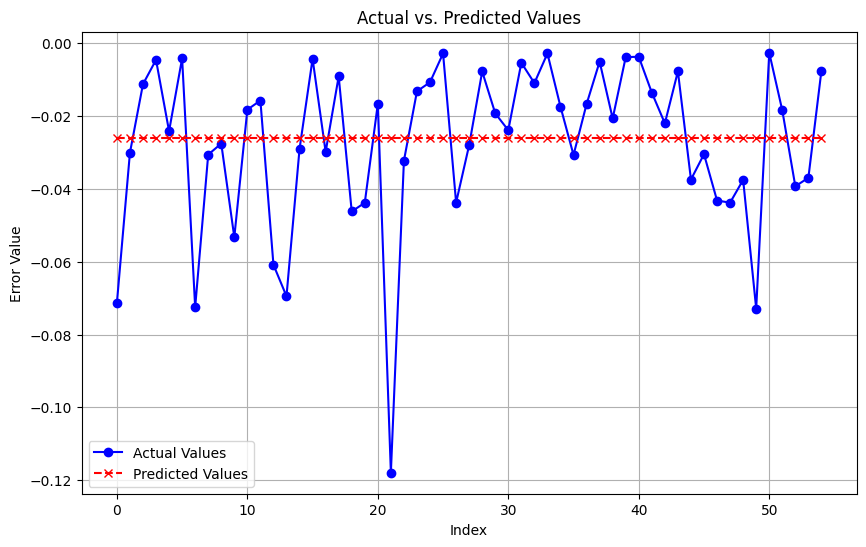

In [ ]:
predictions, model_B_ANN = build_and_predict_ann(Cat_B)

In [ ]:
len(predictions)

48

### Forcasting

In [ ]:
predict_arima_test = result_Arima.predict(start=test_df.index[0], end=test_df.index[-1])

In [ ]:
print(predict_arima_test)

132    6.038160
133    5.987977
134    6.144770
135    6.118288
136    6.159434
137    6.304290
138    6.433280
139    6.446256
140    6.266339
141    6.135871
142    6.007678
143    6.113944
Name: predicted_mean, dtype: float64


In [ ]:
sarimax_forecast_values = predict_arima_test.values
sarimax_forecast_array = np.array(sarimax_forecast_values)
print(sarimax_forecast_array)

[6.03816049 5.98797686 6.14477027 6.11828797 6.15943359 6.30428952
 6.4332799  6.44625582 6.2663389  6.13587078 6.00767775 6.11394411]


In [ ]:
Error_test_list = combined_df['Error'].to_numpy()

In [ ]:
def predict_ann(model, error_list, lags=[1, 2, 12], steps=12):
    test_input = pd.DataFrame(error_list, columns=["Error"])

    for lag in lags:
        test_input[f"Lag_{lag}"] = test_input["Error"].shift(lag)

    # test_input = test_input.dropna()

    X_test = test_input[[f"Lag_{lag}" for lag in lags]].values


    predicted_errors = model.predict(X_test)

    return predicted_errors


In [ ]:
test_predicted_errors_B = predict_ann(model_B_ANN, Error_test_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [ ]:
test_predicted_errors_B = test_predicted_errors_B.flatten()
test_predicted_errors_B

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype=float32)

In [ ]:
def hybrid_forecast(sarimax_forecast, ann_errors, forecast_type):
    ann_errors = np.nan_to_num(ann_errors, nan=0)
    if forecast_type == "A":  # Correct for underestimation (positive errors)
        return sarimax_forecast + ann_errors
    elif forecast_type == "B":  # Correct for overestimation (negative errors)
        return sarimax_forecast - ann_errors
    else:  # "C", the basic SARIMAX forecast
        return sarimax_forecast


In [ ]:
hybrid = hybrid_forecast(sarimax_forecast_array, test_predicted_errors_B, "B")

In [ ]:
print(hybrid)

[6.03816049 5.98797686 6.14477027 6.11828797 6.15943359 6.30428952
 6.4332799  6.44625582 6.2663389  6.13587078 6.00767775 6.11394411]


In [ ]:

def mad(y_true, y_pred):

    return np.mean(np.abs(y_true - y_pred))

def mse(y_true, y_pred):

    return np.mean((y_true - y_pred)**2)

def mape(y_true, y_pred):

    # Avoid division by zero by checking for zero values in y_true
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:
y_true = test_df['Log_Passengers']

In [ ]:
# for hybrid

mad_hybrid = mad(y_true,hybrid)
print("MAD", mad_hybrid)


mse_hybrid = mse(y_true,hybrid)
print("MSE", mse_hybrid)

mpe_hybrid = mape(y_true,hybrid)
print("MAPE", mpe_hybrid)

MAD 0.027993812070988982
MSE 0.0015985893762087379
MAPE 0.4580088769410827


In [ ]:

# def categorize_errors(errors, DLE):
#     if not isinstance(errors, (np.ndarray, list)):
#         raise TypeError("Errors must be a list or numpy array.")
#     if isinstance(errors, list):
#         errors = np.array(errors)

#     n = len(errors)
#     A = errors.copy()
#     B = errors.copy()
#     C = errors.copy()

#     for i in range(n):
#         if errors[i] > DLE:
#             pass  # Keep the value in A
#             B[i] = 0
#             C[i] = 0
#         elif errors[i] < -DLE:
#             A[i] = 0
#             pass # Keep the value in B
#             C[i] = 0
#         else:  # -DLE <= errors[i] <= DLE
#             A[i] = 0
#             B[i] = 0
#             pass # Keep the value in C
#     return A, B, C



In [ ]:

# Example usage:
# errors = error_list
# DLE = DLE

# A, B, C = categorize_errors(errors, DLE)

# print("Errors (E):", errors)
# print("List A (Underestimation):", A)
# print("List B (Overestimation):", B)
# print("List C (Neutral):", C)